In [1]:
import string
import numpy as np
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.engine.input_layer import Input
from keras.layers import add, Dropout, Dense, Embedding, LSTM
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

Using TensorFlow backend.


In [2]:
# Below is the path for the file "Flickr8k.token.txt" on your disk
filename = "flickr8k/Flickr8k_text/Flickr8k.token.txt"
file = open(filename, 'r')
doc = file.read()

descriptions = dict()
for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # take the first token as image id, the rest as description
    image_id = tokens[0]
    image_desc = tokens[1:]
    
    # extract filename from image id
    image_id = image_id.split('.')[0]
    
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    if image_id not in descriptions.keys():
        descriptions[image_id] = list()
    descriptions[image_id].append(image_desc)

In [3]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
filenew = open("flickr8k/Flickr8k_text/descriptions.txt",'w')
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        # tokenize
        desc = desc.split()
        # convert to lower case
        for word in desc:
            word = word.lower()
            # remove punctuation from each token
            word = word.translate(table)
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # store as string
        desc_list[i] =  ' '.join(desc)
        filenew.write(key + " " + desc_list[i] + '\n')
filenew.close()

In [4]:
# No. of distinct words
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 9052


In [5]:
file3 = open('flickr8k/Flickr8k_text/descriptions.txt','r')
doc3 = file3.read()
train_descriptions = dict()
for line in doc3.split('\n'):
    tokens = line.split()
    
    try:
        img_id, img_desc = tokens[0], tokens[1:] 
    except :
        pass
    
    if img_id not in train_descriptions:
        train_descriptions[img_id] = list()
    
    # wrap description in tokens
    desc = 'startseq ' + ' '.join(img_desc) + ' endseq'
    
    # store
    train_descriptions[img_id].append(desc)

print('Descriptions: train=%d' % len(train_descriptions))
file3.close()

Descriptions: train=8092


In [6]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

        
# Consider only words which occur at least 10 times in the corpus
# The actual vocabulary we will use
vocab = list()
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
for w in word_counts:
    if word_counts[w] >= word_count_threshold:
        vocab.append(w)
print('preprocessed words %d ' % len(vocab))
# preprocessed words 1980

preprocessed words 1980 


In [7]:
# Get the InceptionResNetV2 model trained on imagenet data
model = InceptionResNetV2(weights='imagenet')
#model.summary()

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)
#model_new.summary()

In [ ]:
# Convert all the images to size 299x299 as expected by the
# InceptionResNetV2 model
encoded_train_images = dict()
for key in train_descriptions.keys():
    image_path = "Flicker8k_Dataset/" + key + ".jpg"
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess images using preprocess_input() from inception module
    x = preprocess_input(x) 
    # reshape from (1, 1536) to (1536, )
    pred = model_new.predict(x)
    pred = np.reshape(pred, pred.shape[1])
    encoded_train_images[key]=pred

In [41]:
pkl_file = open('encoded_train_images.pkl', 'wb')
pickle.dump(encoded_train_images, pkl_file)
pkl_file.close()

NameError: name 'encoded_train_images' is not defined

In [9]:
ixtoword = {}
wordtoix = {}
ix = 0
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
 all_desc = list()
 for key in descriptions.keys():
  [all_desc.append(d) for d in descriptions[key]]
 return all_desc
# calculate the length of the description with the most words
def max_length(descriptions):
 lines = to_lines(descriptions)
 return max(len(d.split()) for d in lines)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Max Description Length: %d' % max_length)

Max Description Length: 33


In [10]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                #print(X2)
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [11]:
# Load Glove vectors
glove_dir = '../Dataset/glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

vocab_size = len(vocab)
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [12]:
# image feature extractor model
inputs1 = Input(shape=(1536,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model.compile(loss="categorical_crossentropy", optimizer="adam")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1536)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 200)      396000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1536)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [47]:
pkl_file2 = open('encoded_train_imagesb2.pkl', 'rb')
photos = pickle.load(pkl_file2)
pkl_file2.close()

In [49]:
model.fit_generator(data_generator(train_descriptions, photos, wordtoix, max_length,100),epochs=80,steps_per_epoch=20)

Epoch 1/80
20/20 [==============================] - 142s 7s/step - loss: 5.2494
Epoch 2/80
20/20 [==============================] - 134s 7s/step - loss: 5.0132
Epoch 3/80
20/20 [==============================] - 134s 7s/step - loss: 4.8527
Epoch 4/80
20/20 [==============================] - 137s 7s/step - loss: 4.6011
Epoch 5/80
20/20 [==============================] - 136s 7s/step - loss: 4.3584
Epoch 6/80
20/20 [==============================] - 136s 7s/step - loss: 4.2565
Epoch 7/80
20/20 [==============================] - 136s 7s/step - loss: 4.1795
Epoch 8/80
20/20 [==============================] - 138s 7s/step - loss: 4.0676
Epoch 9/80
20/20 [==============================] - 140s 7s/step - loss: 3.9321
Epoch 10/80
20/20 [==============================] - 139s 7s/step - loss: 3.8657
Epoch 11/80
20/20 [==============================] - 137s 7s/step - loss: 3.8558
Epoch 12/80
20/20 [==============================] - 140s 7s/step - loss: 3.8048
Epoch 13/80
20/20 [==================

In [50]:
#Save model
model.save("img_cap_f8k.h5")

In [14]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_final.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [15]:
model_final = load_model('img_cap_f8k.h5')

Instructions for updating:
Use tf.cast instead.


In [22]:
file5 = open("flickr8k/Flickr8k_text/Flickr_8k.testImages.txt","r")
test = file5.read().split("\n")
file6 = open("Generated_Captions.txt",'w')
i=1
for image_name in test:
    image_path = "flickr8k/Flicker8k_Dataset/" + image_name
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess images using preprocess_input() from inception module
    x = preprocess_input(x) 
    # reshape from (1, 1536) to (1536, )
    pred = model_new.predict(x)
    caption = greedySearch(pred)
    file6.write(image_name.split('.')[0] + " " + caption + '\n')
    i+=1
file5.close()
file6.close()

Two men are sitting on bench


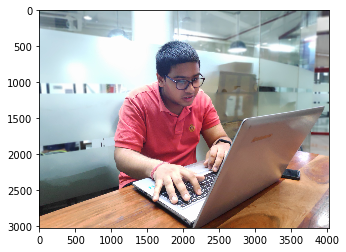

In [18]:
import string
import numpy as np
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.engine.input_layer import Input
from keras.layers import add, Dropout, Dense, Embedding, LSTM
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

image_name = "IMG_20181008_145626.jpg"
image_path = "flickr8k/Flicker8k_Dataset/" + image_name    
img = image.load_img(image_path, target_size=(299, 299))
# Convert PIL image to numpy array of 3-dimensions
x = image.img_to_array(img)
# Add one more dimension
x = np.expand_dims(x, axis=0)
# preprocess images using preprocess_input() from inception module
x = preprocess_input(x) 
# reshape from (1, 1536) to (1536, )
pred = model_new.predict(x)
caption = greedySearch(pred)
print(caption)
image=mpimg.imread(image_path)
imgplot = plt.imshow(image)